* 核心思想：将每两年作为一个时间窗口，计算转移概率矩阵，得到5个转移矩阵（因为10年总共5个两年窗口）。

* 对比方法：直接计算前后两个转移矩阵之间的变化，判断是否存在明显变化（例如使用JS散度）。

* 判定分化点：如果前后两个转移概率矩阵变化显著，则认为这是一个“分化点”。

## 实现方案：

* Step 1: 数据预处理：按国家分类，提取职业序列。
* Step 2: 构建两年窗口的转移矩阵：每隔两年计算一次转移概率矩阵，共5个。
* Step 3: 计算前后窗口转移矩阵的变化（JS散度）：比较每相邻两个矩阵，计算JS散度，判断变化是否显著。
* Step 4: 判断分化点：设置JS散度阈值，大于该值则认为发生分化。
* Step 5: 结果可视化：绘制JS散度随时间的变化曲线，标出显著分化点。

In [14]:
import pandas as pd
import numpy as np
import itertools
from sklearn.metrics import pairwise_distances
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy

df = pd.read_csv("/Users/lei/Documents/Sequenzo_all_folders/sequenzo_local/test_data/real_data_my_paper/detailed_sequence_10_work_years_df.csv")

time_cols = [f"C{i}" for i in range(1, 11)]  # C1~C10

# 找到所有以 "C" 开头的列，并将其值转换为字符串
career_columns = [col for col in df.columns if col.startswith("C")]
df[career_columns] = df[career_columns].astype(str)

# 假设 'country' 是一列，值为 'India' 或 'US'
india_df = df[df["country"] == "india"].copy()
us_df = df[df["country"] == "us"].copy()

india_df

,worker_id,gender,country,cohort,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
0,dilip-kumar-nath-7538746a,male,india,11-20 total work years,software,software,software,software,software,software,software,software,software,software
1,vinodkumar-yadav-b7a976107,male,india,11-20 total work years,software,software,software,software,software,software,software,software,software,software
2,josh-slosson-07a1509,male,india,11-20 total work years,software,software,software,software,software,software,software,software,software,software
3,jonatthan-rodriguez-8a5612121,male,india,11-20 total work years,software,software,software,software,software,software,software,software,software,software
4,jeenesh-jyothindran-8ba28818,male,india,11-20 total work years,software,software,software,software,software,software,software,software,software,software
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15108,neha-grover-85883655,female,india,0-10 total work years,software,software,software,software,software,software,software,software,software,software
15109,amrita-bhatt-5126694a,female,india,0-10 total work years,hardware,hardware,hardware,software,software,software,support & test,support & test,support & test,support & test
15110,renukaa-thiyagarajan-21a6b565,female,india,0-10 total work years,software,software,software,software,software,software,software,software,software,software
15111,sruthi-jayaraj-5b46302a,female,india,11-20 total work years,support & test,support & test,support & test,support & test,support & test,support & test,support & test,support & test,support & test,support & test


## 研究问题一：何时职业轨迹开始分化？模型选择：马尔可夫模型 (HMM)

* 使用职业状态簇（如IT开发、管理、支持）作为隐含状态。
* 分析隐含状态的转移概率变化，识别分化节点。

### 结果解读：

* 隐含状态序列可视化：可以看到状态变化的趋势，如某些时间点急剧变化，表示职业轨迹的分化。
* 状态转移率计算：如果某些时间点的转移率显著大于均值+标准差，说明此时发生职业分化。
* 分化节点：如果某个时间点（如第3年）转移率剧增，说明此时职业路径开始分化。

Country: India, Window: 1-2
States: ['data', 'data & intensive math', 'hardware', 'research', 'software', 'software & hardware', 'support & test']
Transition Matrix:
[[9.19178082e-01 4.10958904e-03 8.21917808e-03 1.36986301e-03
  2.46575342e-02 2.73972603e-02 1.50684932e-02]
 [5.60747664e-03 9.19626168e-01 7.47663551e-03 1.86915888e-03
  3.92523364e-02 1.12149533e-02 1.49532710e-02]
 [3.44234079e-03 1.03270224e-02 9.29432014e-01 0.00000000e+00
  3.78657487e-02 1.37693632e-02 5.16351119e-03]
 [0.00000000e+00 1.66666667e-02 0.00000000e+00 8.75000000e-01
  1.00000000e-01 0.00000000e+00 8.33333333e-03]
 [4.15709441e-03 4.92287496e-03 5.46986107e-03 1.85975276e-03
  9.60835795e-01 1.12679138e-02 1.14867082e-02]
 [3.26950023e-03 1.40121439e-03 7.94021485e-03 4.67071462e-04
  3.40962167e-02 9.42550210e-01 1.02755722e-02]
 [6.97050938e-03 5.36193029e-03 8.04289544e-03 0.00000000e+00
  3.32439678e-02 1.28686327e-02 9.33512064e-01]]

Country: India, Window: 3-4
States: ['data', 'data & intensive

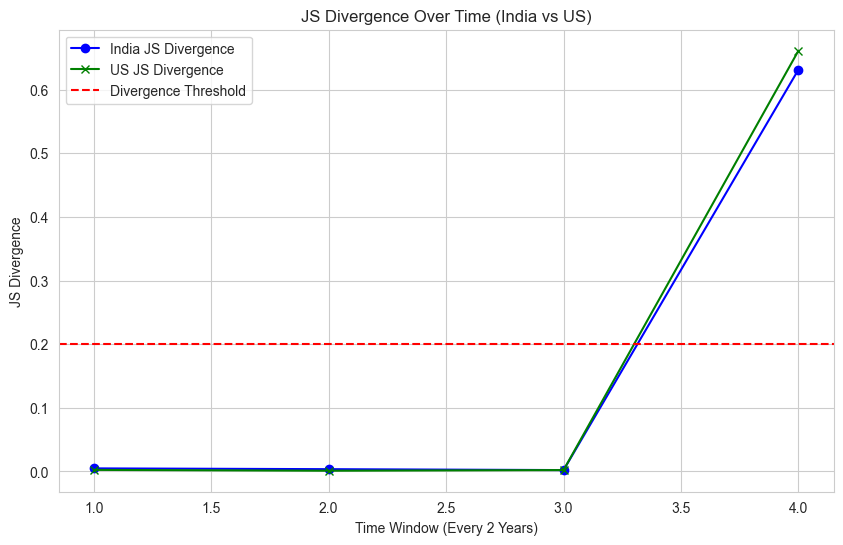

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Step 1: 数据预处理
df = pd.read_csv("/Users/lei/Documents/Sequenzo_all_folders/sequenzo_local/test_data/real_data_my_paper/detailed_sequence_10_work_years_df.csv")

# 按国家分类提取职业序列
career_columns = [f"C{i}" for i in range(1, 11)]  # C1~C10
df[career_columns] = df[career_columns].astype(str)

india_df = df[df["country"] == "india"].copy()
us_df = df[df["country"] == "us"].copy()

# JS散度计算函数
def js_divergence(P, Q):
    P = np.array(P) + 1e-10
    Q = np.array(Q) + 1e-10
    M = 0.5 * (P + Q)
    return 0.5 * (entropy(P, M) + entropy(Q, M))

# 计算转移概率矩阵
def transition_matrix(data):
    states = sorted(set(map(str, data.flatten())))
    n = len(states)
    matrix = np.zeros((n, n))
    state_to_idx = {state: idx for idx, state in enumerate(states)}

    for sequence in data:
        for (i, j) in zip(sequence[:-1], sequence[1:]):
            if i in state_to_idx and j in state_to_idx:
                matrix[state_to_idx[i], state_to_idx[j]] += 1

    # 归一化为转移概率
    row_sums = matrix.sum(axis=1, keepdims=True)
    matrix = np.divide(matrix, row_sums, where=row_sums != 0)
    return matrix, states

# 计算两年窗口转移矩阵
def calculate_transition_matrices(df, country_name):
    matrices = []
    for start in range(1, 10, 2):  # 每两年为一个窗口，共5个窗口
        window = df.iloc[:, start:start+2].to_numpy()
        matrix, states = transition_matrix(window)
        print(f"Country: {country_name}, Window: {start}-{start+1}\nStates: {states}\nTransition Matrix:\n{matrix}\n")
        matrices.append(matrix)
    return matrices

# 计算窗口间的JS散度
def calculate_js_series(matrices, country_name):
    js_values = []
    for i in range(len(matrices) - 1):
        js_value = js_divergence(matrices[i].flatten(), matrices[i+1].flatten())
        print(f"Country: {country_name}, JS Divergence between Window {i+1} and {i+2}: {js_value:.4f}")
        js_values.append(js_value)
    return js_values

# 绘制JS散度变化曲线（双国家对比）
def plot_js_divergence(india_js, us_js):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(india_js) + 1), india_js, marker='o', linestyle='-', color='blue', label='India JS Divergence')
    plt.plot(range(1, len(us_js) + 1), us_js, marker='x', linestyle='-', color='green', label='US JS Divergence')
    plt.axhline(y=0.2, color='red', linestyle='--', label='Divergence Threshold')
    plt.title("JS Divergence Over Time (India vs US)")
    plt.xlabel("Time Window (Every 2 Years)")
    plt.ylabel("JS Divergence")
    plt.legend()
    plt.show()

# Step 2: 计算转移矩阵
india_matrices = calculate_transition_matrices(india_df[career_columns], "India")
us_matrices = calculate_transition_matrices(us_df[career_columns], "US")

# Step 3: 计算JS散度序列
india_js_series = calculate_js_series(india_matrices, "India")
us_js_series = calculate_js_series(us_matrices, "US")

# Step 5: 结果可视化
plot_js_divergence(india_js_series, us_js_series)


## 那 individual-level indicators？

* Prefix Tree的优势：
    * 可以捕捉个体级别的路径分化，计算Prefix Rarity Score和Path Uniqueness，明确“谁”在“何时”分化。
    * 尤其在职业路径复杂和长期变化的场景下表现优异。

* Markov链的局限：
    * 一般用于全局转移概率的计算，而非个体级别的变化跟踪。
    * 常用于短期转移模式检测，但难以捕捉长期路径多样性。

能否用于个体级别分析？理论上可以：每个个体都有其独立的转移概率矩阵。

实际问题：样本量过小，个体路径有限，导致转移概率矩阵稀疏且不稳定。

In [33]:
import pandas as pd
import numpy as np
from scipy.stats import entropy

# 数据读取
df = pd.read_csv("/Users/lei/Documents/Sequenzo_all_folders/sequenzo_local/test_data/real_data_my_paper/detailed_sequence_10_work_years_df.csv")
career_columns = [f"C{i}" for i in range(1, 11)]
df[career_columns] = df[career_columns].astype(str)

# 按国家分类
india_df = df[df["country"] == "india"].copy()
us_df = df[df["country"] == "us"].copy()

# JS散度计算函数
def js_divergence(P, Q):
    P = np.array(P) + 1e-10
    Q = np.array(Q) + 1e-10
    M = 0.5 * (P + Q)
    return 0.5 * (entropy(P, M) + entropy(Q, M))

# 计算转移概率矩阵（增加调试信息）
def transition_matrix(sequence):
    try:
        # 打印输入序列（调试用）
        # print(f"原始序列: {sequence}")
        
        # 去除空字符串和NaN
        sequence = [str(x).strip() for x in sequence if str(x) != 'nan' and str(x).strip() != '']
        # print(f"清洗后序列: {sequence}")

        states = sorted(set(sequence))
        # print(f"状态集合: {states}")

        if len(states) == 0:
            print("警告：状态集合为空")
            return np.zeros((1, 1)), []

        n = len(states)
        matrix = np.zeros((n, n))
        state_to_idx = {state: idx for idx, state in enumerate(states)}
        # print(f"状态索引映射: {state_to_idx}")

        for (i, j) in zip(sequence[:-1], sequence[1:]):
            if i in state_to_idx and j in state_to_idx:
                matrix[state_to_idx[i], state_to_idx[j]] += 1

        # 归一化为转移概率
        row_sums = matrix.sum(axis=1, keepdims=True)
        matrix = np.divide(matrix, row_sums, where=row_sums != 0)
        # print(f"转移矩阵: \n{matrix}")
        return matrix, states
    except Exception as e:
        print(f"Error processing sequence: {sequence}, Error: {str(e)}")
        return np.zeros((1, 1)), []

# 计算个体级特征
def calculate_individual_features(df):
    features = []
    threshold = 0.2  # JS散度阈值

    for worker_id, group in df.groupby("worker_id"):
        matrices = []
        js_values = []

        # 计算每个窗口的JS散度
        for start in range(1, 10, 2):
            sequence = group.iloc[0, start:start+2].values
            # 正确解包转移矩阵
            matrix, _ = transition_matrix(sequence)
            matrices.append(matrix)

        for i in range(len(matrices) - 1):
            # 正确解包后使用flatten
            js_value = js_divergence(matrices[i].flatten(), matrices[i+1].flatten())
            js_values.append(js_value)

        # 特征提取
        cumulative_js = np.sum(js_values) if js_values else 0
        max_js = np.max(js_values) if js_values else 0
        divergence_year = next((i + 1 for i, js in enumerate(js_values) if js > threshold), None)
        change_rate = (np.mean(js_values[-2:]) - np.mean(js_values[:2])) / len(js_values) if len(js_values) >= 2 else 0

        features.append([worker_id, cumulative_js, max_js, divergence_year, change_rate])

    return pd.DataFrame(features, columns=["worker_id", "cumulative_js", "max_js", "divergence_year", "change_rate"])

# 计算特征
india_features = calculate_individual_features(india_df)
us_features = calculate_individual_features(us_df)

# 特征汇总
features_df = pd.concat([india_features, us_features], ignore_index=True)
print(features_df.head())

# 保存特征数据
features_df.to_csv("individual_js_features.csv", index=False)


/Users/lei/Documents/Sequenzo_all_folders/Sequenzo-main/venv/lib/python3.11/site-packages/scipy/stats/_entropy.py:151: RuntimeWarning: invalid value encountered in divide
  qk = 1.0*qk / np.sum(qk, **sum_kwargs)  # type: ignore[operator, call-overload]
/Users/lei/Documents/Sequenzo_all_folders/Sequenzo-main/venv/lib/python3.11/site-packages/scipy/stats/_entropy.py:151: RuntimeWarning: invalid value encountered in divide
  qk = 1.0*qk / np.sum(qk, **sum_kwargs)  # type: ignore[operator, call-overload]


                                           worker_id  cumulative_js   max_js  \
0       %7E%7E%7Eabhishek%7E%7E%7E-lifoline-4ba22719       3.271605  2.99846   
1           %7E%7E%7Etrisha%7E%7E%7E-mondal-a0237473       3.134395  2.99846   
2  %E2%97%8F%E0%B9%8B-b%C3%A1%DA%A9t%C3%BD%C3%A1v...       3.059786  2.99846   
3           %EF%A3%BF-sahil-dhiman%EF%A3%BF-15b18441       3.053004  2.99846   
4           %ef%a3%bf-sahil-dhiman%ef%a3%bf-15b18441       3.052382  2.99846   

   divergence_year  change_rate  
0                1    -0.408951  
1                2    -0.391799  
2                2    -0.382473  
3                2    -0.381625  
4                2    -0.381548  


In [41]:

# 提取worker_id和国家信息
country_info = df[["worker_id", "country"]].drop_duplicates()

features_df = pd.concat([india_features, us_features], ignore_index=True)

# 合并国家信息到特征数据
features_df = pd.merge(features_df, country_info, on="worker_id")

features_df
features_df.to_csv("individual_js_features.csv", index=False)

可视化：个体级Markov链特征对比

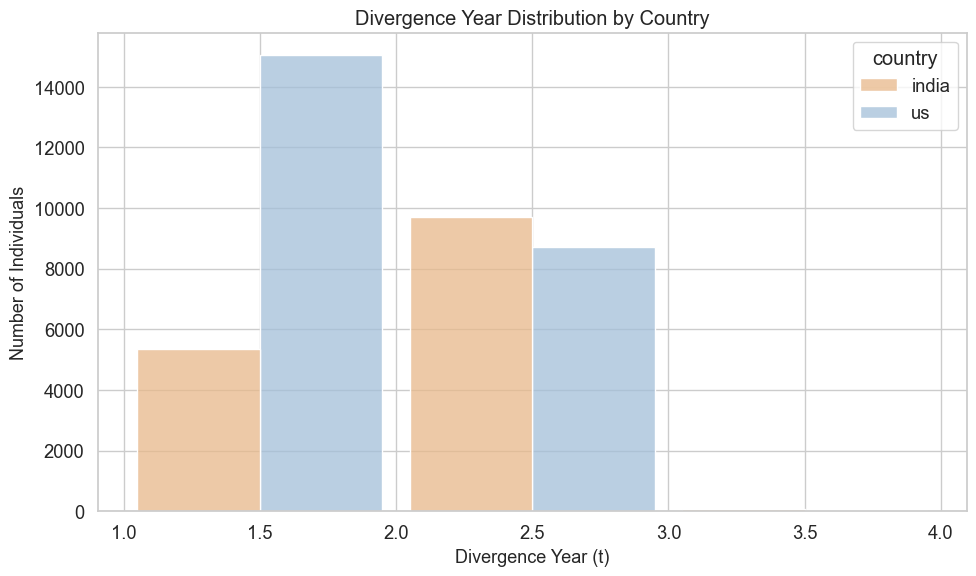

/Users/lei/Documents/Sequenzo_all_folders/Sequenzo-main/venv/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


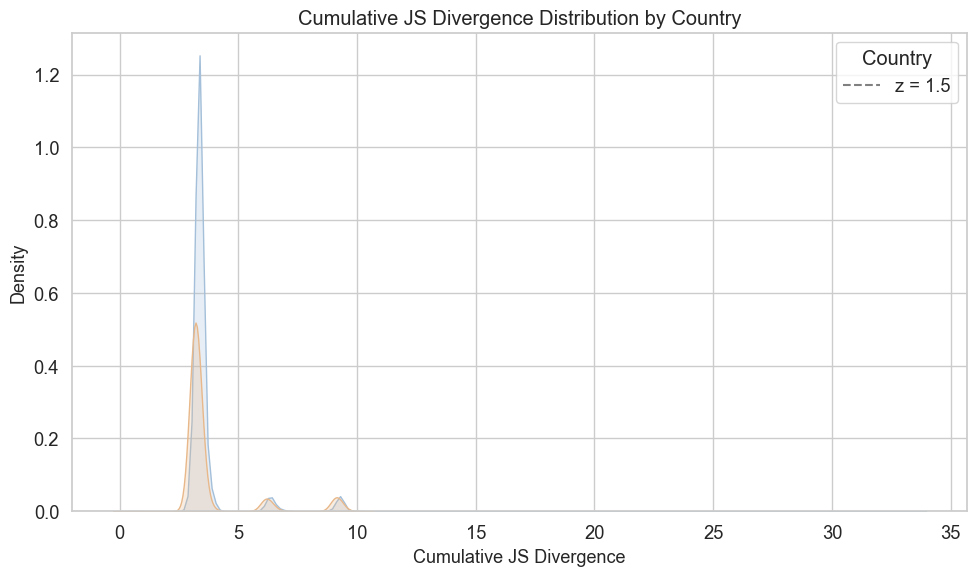

/var/folders/kk/h5dw00r5357gxylmmb8zl7qw0000gn/T/ipykernel_63933/3888477011.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="country", y="max_js", data=df, palette=palette)


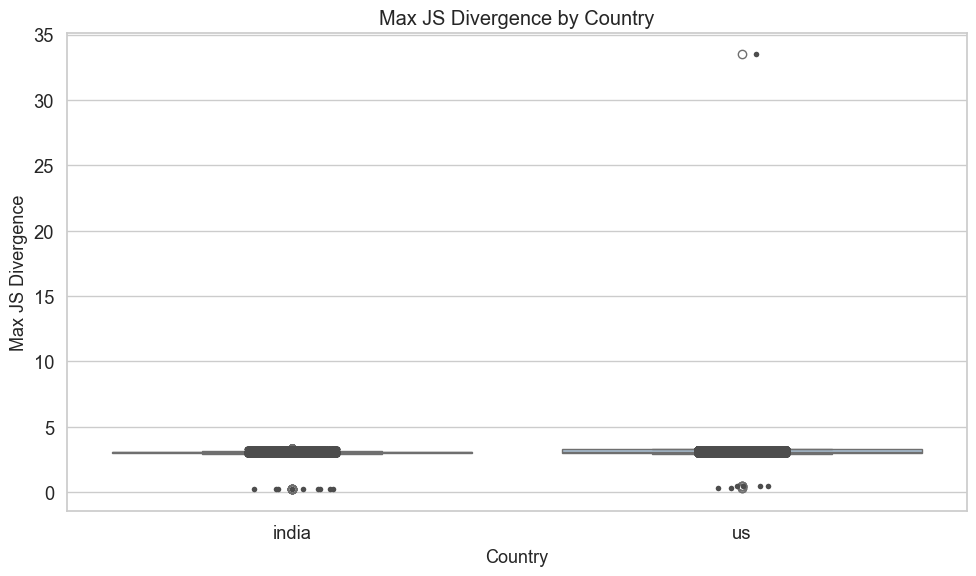

/Users/lei/Documents/Sequenzo_all_folders/Sequenzo-main/venv/lib/python3.11/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


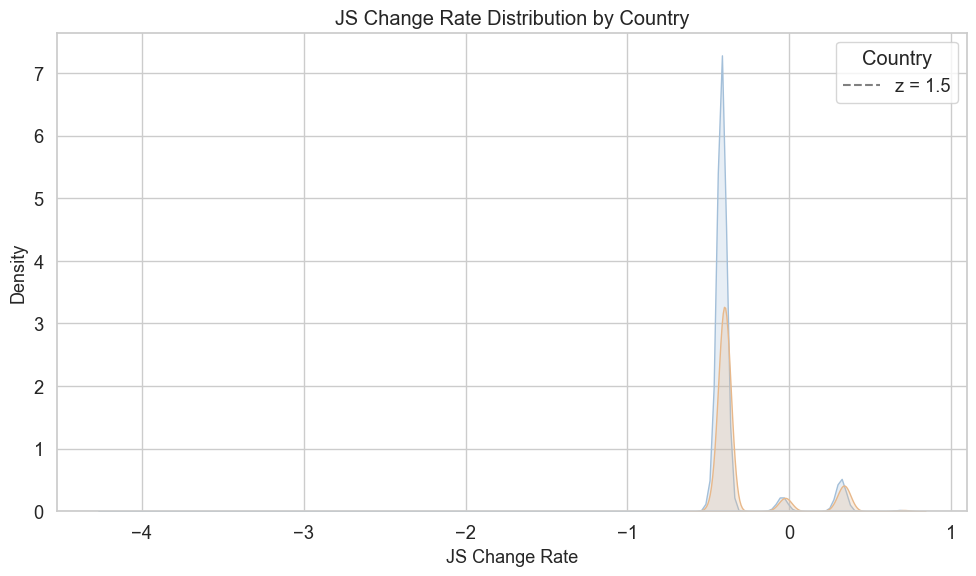

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 加载特征数据
features_df = pd.read_csv("individual_js_features.csv")

# 颜色设置（莫奈柔色调）
india_color = "#E8B88A"
us_color = "#A3BFD9"
palette = {"india": india_color, "us": us_color}

# 统一标签格式（直接使用country字段）
features_df["country"] = features_df["country"].str.lower().str.strip()

sns.set(style="whitegrid", font_scale=1.2)

# 绘制Divergence Year分布对比
def plot_divergence_year_distribution(df):
    plt.figure(figsize=(10, 6))
    sns.histplot(
        data=df,
        x="divergence_year",
        hue="country",
        multiple="dodge",
        binwidth=1,
        shrink=0.9,
        palette=palette,
        stat="count",
        common_norm=False
    )
    plt.xlabel("Divergence Year (t)", fontsize=13)
    plt.ylabel("Number of Individuals", fontsize=13)
    plt.title("Divergence Year Distribution by Country")
    plt.tight_layout()
    plt.savefig("Divergence_Year_Distribution_by_Country.png", dpi=300)
    plt.show()

# 绘制Cumulative JS Score分布（KDE）
def plot_cumulative_js_distribution(df):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=df, x="cumulative_js", hue="country", fill=True, palette=palette)
    mean, std = df["cumulative_js"].mean(), df["cumulative_js"].std()
    plt.axvline(mean + 1.5 * std, color="grey", linestyle="--", label="z = 1.5")
    plt.xlabel("Cumulative JS Divergence", fontsize=13)
    plt.ylabel("Density", fontsize=13)
    plt.title("Cumulative JS Divergence Distribution by Country")
    plt.legend(title="Country")
    plt.tight_layout()
    plt.savefig("Cumulative_JS_Divergence_Distribution_by_Country.png", dpi=300)
    plt.show()

# 绘制Max JS Divergence分布（箱线图 + Strip Plot）
def plot_max_js_boxplot(df):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="country", y="max_js", data=df, palette=palette)
    sns.stripplot(x="country", y="max_js", data=df, size=4, color=".3", jitter=True)
    plt.xlabel("Country", fontsize=13)
    plt.ylabel("Max JS Divergence", fontsize=13)
    plt.title("Max JS Divergence by Country")
    plt.tight_layout()
    plt.savefig("Max_JS_Divergence_by_Country.png", dpi=300)
    plt.show()

# 绘制JS Change Rate分布（KDE）
def plot_change_rate_distribution(df):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=df, x="change_rate", hue="country", fill=True, palette=palette)
    mean, std = df["change_rate"].mean(), df["change_rate"].std()
    plt.axvline(mean + 1.5 * std, color="grey", linestyle="--", label="z = 1.5")
    plt.xlabel("JS Change Rate", fontsize=13)
    plt.ylabel("Density", fontsize=13)
    plt.title("JS Change Rate Distribution by Country")
    plt.legend(title="Country")
    plt.tight_layout()
    plt.savefig("JS_Change_Rate_Distribution_by_Country.png", dpi=300)
    plt.show()

# 绘制所有图形
plot_divergence_year_distribution(features_df)
plot_cumulative_js_distribution(features_df)
plot_max_js_boxplot(features_df)
plot_change_rate_distribution(features_df)
